# Spaceshift Titanic

# LogBook

In [1]:
# 7 Oct 2022 --> Proyect Start
# 15 Oct 2022 --> Proyect Publication


# Author: Andres Montes de Oca
# GitHub: https://github.com/AndresMontesDeOca

# Load Data and Info

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

# Ignorar Warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='white', context='notebook', palette='pastel')

train = pd.read_csv('Data/train.csv')
data = train
test = pd.read_csv('Data/test.csv')

print(data.info())
display(data.head())
# display(data.describe())
# display(data.describe(include='object'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Individual Features Check

## Transported (Target)

True     4378
False    4315
Name: Transported, dtype: int64 



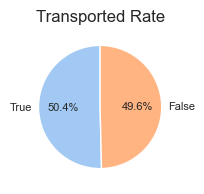

In [3]:
print(data['Transported'].value_counts(), '\n')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
data['Transported'].value_counts().plot(kind='pie', 
        autopct='%.1f%%', textprops={'fontsize':8}, startangle=90).set_title('Transported Rate')
ax.set_ylabel('')
plt.show()

# We will use it later
mask_transported = data['Transported']==True

# Transported is well balanced

## PassengerId (Feature)

In [4]:
print('Nulls:', data.PassengerId.isnull().sum(), '\n')
print(data.PassengerId.head())

# We will have to split the GroupId form this Feature, there are no nulls

Nulls: 0 

0    0001_01
1    0002_01
2    0003_01
3    0003_02
4    0004_01
Name: PassengerId, dtype: object


## GroupSize (Created Feature)

1    4805
2    1682
3    1020
4     412
5     265
7     231
6     174
8     104
Name: GroupSize, dtype: int64


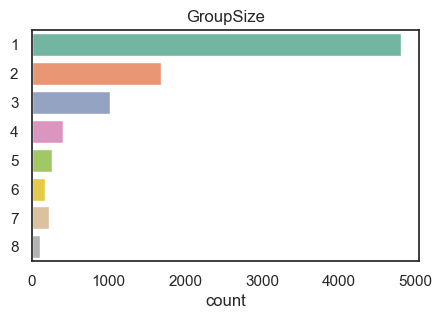

In [5]:
# GroupId and GroupSize feature generation

data['GroupId'] = data['PassengerId'].str.split('_', expand=True)[0]

# Grouping by GroupId to count each group size
GroupId_size_serie = data.groupby('GroupId').size() # temp GroupId_size Serie
GroupId_size_serie.rename('GroupSize', inplace=True) # necesary for the Join

# First we add how many passengers are in the group
data = pd.merge(left=data, right=GroupId_size_serie, left_on='GroupId', right_on='GroupId', how='left')

print(data['GroupSize'].value_counts())

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.countplot(y=data['GroupSize'], palette='Set2')
ax.set_ylabel('')

plt.title('GroupSize')
plt.show()

# Few Passangers in big groups

## IsAlone (Created Feature)

True     4805
False    3888
Name: IsAlone, dtype: int64 



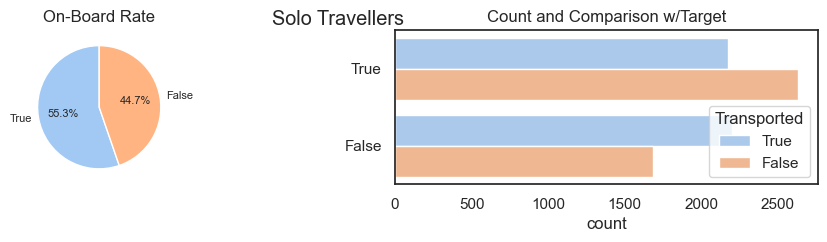

In [6]:
# IsAlone Feature Generation (Solo Travelers)

# Then we filter just the solo travelelrs
data.loc[:, 'IsAlone'] = data['GroupSize']==1 # Or we can leave it as it is, maybe improves the results
# data.rename(columns={'Group_size':'IsAlone'}, inplace=True)

print(data['IsAlone'].value_counts(), '\n')
# Plots
fig, ax = plt.subplots(1, 2, figsize=(12, 2))

# ax[0]
data['IsAlone'].value_counts(dropna=False).sort_index(ascending=False).plot(kind='pie', autopct='%.1f%%', ax=ax[0], 
                                                                            startangle=90, textprops={'fontsize':8})
ax[0].set_ylabel('')
ax[0].set_title('On-Board Rate')

# ax[1]
sns.countplot(y=data['IsAlone'], hue=data['Transported'], ax=ax[1], order=[True, False], hue_order=[True, False])
ax[1].set_ylabel('')
ax[1].set_title('Count and Comparison w/Target')

fig.suptitle('Solo Travellers\n')
plt.show()

# There are more Solo Travellers, but they have lower Transported Rate

## HomePlanet (Feature)

Earth     4602
Europa    2131
Mars      1759
NaN        201
Name: HomePlanet, dtype: int64


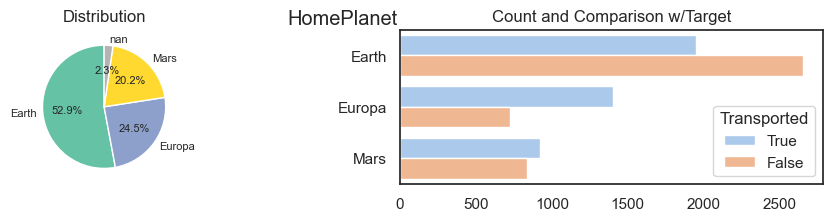

In [7]:
print(data['HomePlanet'].value_counts(dropna=False))

# Plots
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
data['HomePlanet'].value_counts(dropna=False).plot(kind='pie', autopct='%.1f%%', ax=ax[0], 
                                    startangle=90, cmap='Set2', textprops={'fontsize':8})
ax[0].set_ylabel('')
ax[0].set_title('Distribution')
sns.countplot(y=data['HomePlanet'], order=data['HomePlanet'].value_counts().index, ax=ax[1], 
              hue=data['Transported'], hue_order=[True, False])
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('Count and Comparison w/Target')

fig.suptitle('HomePlanet')
plt.show()

# There are 201 nulls
# Most coming from Earth
# Passangers from Europe have more chances to be Transported
# Pending: Reduce annot_size for the PieChart

## CryoSleep (Feature)

True     3037
False    5439
NaN       217
Name: CryoSleep, dtype: int64


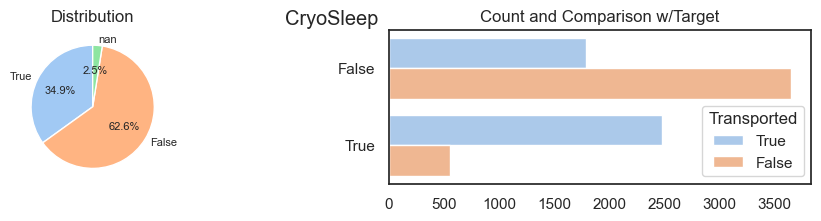

In [8]:
print(data['CryoSleep'].value_counts(dropna=False).sort_index(ascending=False))

# Plots
fig, ax = plt.subplots(1, 2, figsize=(12, 2))

# ax[0]
data['CryoSleep'].value_counts(dropna=False).sort_index(ascending=False).plot(kind='pie', 
                        autopct='%.1f%%', ax=ax[0], startangle=90, textprops={'fontsize':8})
ax[0].set_ylabel('')
ax[0].set_title('Distribution')

# ax[1]
sns.countplot(y=data['CryoSleep'], hue=data['Transported'], ax=ax[1], hue_order=[True, False])
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('Count and Comparison w/Target')

fig.suptitle('CryoSleep')
plt.show()

# Just 1/3 are in CryoSleep
# There are 217 Nulls
# Strong correlation with Target Variable

#### Correlation with VIP

Total VIP Passengers: 199


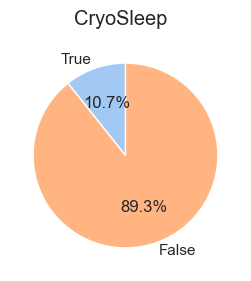

In [9]:
print('Total VIP Passengers:', data[data.VIP==True].shape[0])

# Plot
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
data[data.VIP==True].CryoSleep.value_counts().sort_index(ascending=False).plot(kind='pie', autopct='%.1f%%', startangle=90)
ax.set_ylabel('')
plt.suptitle('CryoSleep')
plt.show()

# There few VIP Passengers
# Strong correlation, VIP passengers dont want to be put to sleep

#### Correlation with Age

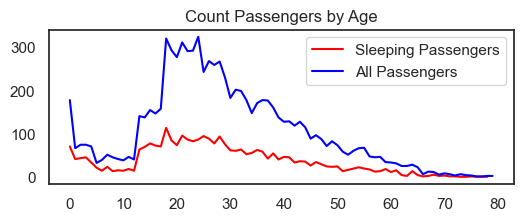

In [10]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
data[data.CryoSleep==True].Age.value_counts().sort_index().plot(title='Count Passengers by Age', color='red', label='Sleeping Passengers')
data.Age.value_counts().sort_index().plot(color='blue', label='All Passengers')

plt.legend()
plt.show()

# Most Seniors (+65 years) are put to sleep, but they are few
# Same happens with kids (0 to 12 years)????
# The gap between both gets gradually reduced for adults (18 to 65 years) 

#### Correlation with GroupSize

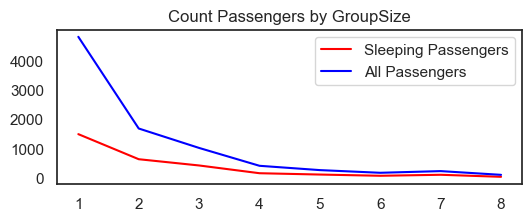

In [11]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
data[data.CryoSleep==True].GroupSize.value_counts().sort_index().plot(title='Count Passengers by GroupSize', 
                                                                      color='red', label='Sleeping Passengers')
data.GroupSize.value_counts().sort_index().plot(color='blue', label='All Passengers')

plt.yticks(np.arange(0, 5000, 1000))
plt.legend()
plt.show()

# The bigger the GroupSize, more chances of CryoSleep?

### FillNa

In [12]:
# For later
# print('Nulls Count Original:', data[data.CryoSleep.isnull()].shape[0], '\n')

# Complete with VIPs (90% Rate)
# data.loc[data.CryoSleep.isnull() & data.VIP, 'CryoSleep']=False # 214 to go
# print('Nulls Count after VIPs:', data[data.CryoSleep.isnull()].shape[0], '\n')

# Complete for Kids and Seniors (to be tested)
# data.loc[data.CryoSleep.isnull() & np.logical_or(data.Age>=65, data.Age<=12), 'CryoSleep'] = True
# print('Nulls Count after Age:', data[data.CryoSleep.isnull()].shape[0], '\n')

## Cabin (Feature)

In [13]:
# The cabin number where the passenger is staying. Takes the form deck/num/side, 
# where side can be either P for Port or S for Starboard.

print('Nulls Count Cabin:', data[data.Cabin.isnull()].shape[0], '\n')
print(data['Cabin'].head()) # PortSide/StarboardSide: Left/Right

Nulls Count Cabin: 199 

0    B/0/P
1    F/0/S
2    A/0/S
3    A/0/S
4    F/1/S
Name: Cabin, dtype: object


#### FillNa (GroupId Approach)

In [14]:
# GroupID DIM table for completing NA values
GroupId_DIM = data[['GroupId', 'Cabin']].drop_duplicates(subset='GroupId').set_index('GroupId').squeeze()
display(GroupId_DIM.head())

data.Cabin.fillna('GroupId_DIM')

# SQL Merge (should be an easier way for sure)
data.loc[data.Cabin.isnull(), 'Cabin']= pd.merge(left=data.loc[data.Cabin.isnull()][['GroupId', 'Cabin']],
         right=GroupId_DIM,
         how='left',
         left_on='GroupId',
         right_index=True
        )['Cabin_y']

print('Nulls Count Cabin:', data[data.Cabin.isnull()].shape[0], '\n')

# There will be another fillna() for each individual fature after split (Deck, Num, Side)

GroupId
0001    B/0/P
0002    F/0/S
0003    A/0/S
0004    F/1/S
0005    F/0/P
Name: Cabin, dtype: object

Nulls Count Cabin: 134 



#### Split (Cabin)

In [15]:
col_names = ['Deck', 'Num', 'Side']
data_Cabin = data['Cabin'].str.split('/', expand=True).set_axis(col_names, axis=1)

# Converting Num to Int
data_Cabin.loc[data_Cabin.Num.notnull(), 'Num'] = \
                data_Cabin.loc[data_Cabin.Num.notnull()].Num.astype(int) # Probably there is an easier way

display(data_Cabin)

# Concat
data = pd.concat([data, data_Cabin], axis=1)

,Deck,Num,Side
0,B,0,P
1,F,0,S
2,A,0,S
3,A,0,S
4,F,1,S
...,...,...,...
8688,A,98,P
8689,G,1499,S
8690,G,1500,S
8691,E,608,S


## Deck (Created Feature)

F      2804
G      2578
E       880
B       790
C       758
D       483
A       261
NaN     134
T         5
Name: Deck, dtype: int64


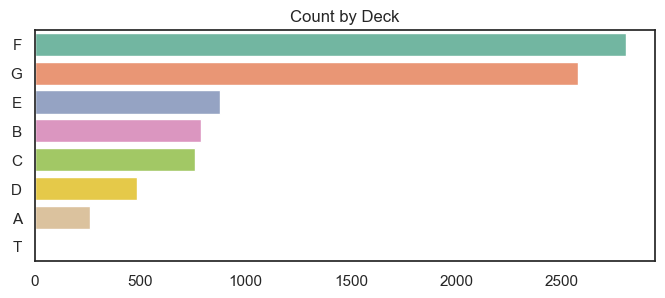

In [16]:
# Working but ugly
print(data['Deck'].value_counts(dropna=False))

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
sns.countplot(y=data['Deck'], palette='Set2', order=data['Deck'].value_counts().index)
ax.set_ylabel('')
ax.set_xlabel('')

plt.title('Count by Deck')
plt.show()

# 199 nulls

## Side (Created Feature)

S      4323
P      4236
NaN     134
Name: Side, dtype: int64


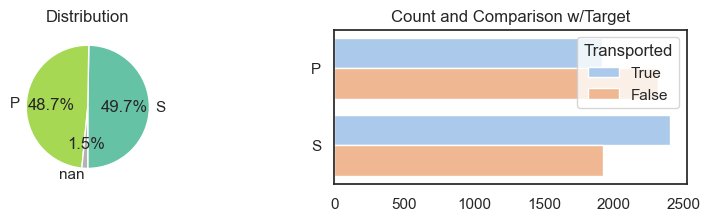

Nulls for Deck, Side and Num are the same: 134


In [17]:
print(data.Side.value_counts(dropna=False))

# Plot
fix, ax = plt.subplots(1, 2, figsize=(10, 2))

# ax[0]
data['Side'].value_counts(dropna=False).sort_index(ascending=False). \
                    plot(kind='pie', autopct='%.1f%%', ax=ax[0], startangle=270, cmap='Set2')
ax[0].set_ylabel('')
ax[0].set_title('Distribution')

# ax[1]
sns.countplot(y=data['Side'], hue=data['Transported'], ax=ax[1], hue_order=[True, False])
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('Count and Comparison w/Target')
plt.show()

# Same # nulls as Deck, maybe are related?
print('Nulls for Deck, Side and Num are the same:', \
      data[data.Deck.isnull() & data.Side.isnull() & data.Num.isnull()].shape[0]) # 199 = All the same

## Num (Created Feature)

In [18]:
print('Nulls:', data['Num'].isnull().sum(), '\n')

Nulls: 134 



In [19]:
# Checking boat simetry
Cabin_P_F = data[(data.Side=='P') & (data.Deck=='F')].groupby(['Side', 'Deck', 'Num']).size().to_frame('Count')
Cabin_S_F = data[(data.Side=='S') & (data.Deck=='F')].groupby(['Side', 'Deck', 'Num']).size().to_frame('Count')

display(Cabin_P_F)
display(Cabin_S_F)

# I dont know how to handle missing Num

Count
Side Deck Num        
P    F    0         1
          1         1
          2         1
          3         1
          4         1
...               ...
          1888      2
          1891      1
          1892      1
          1893      1
          1894      1

[1218 rows x 1 columns]

Count
Side Deck Num        
S    F    0         1
          1         1
          2         1
          3         1
          6         1
...               ...
          1787      1
          1788      1
          1789      1
          1792      1
          1793      1

[1157 rows x 1 columns]

## Destination (Feature)

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
NaN               182
Name: Destination, dtype: int64


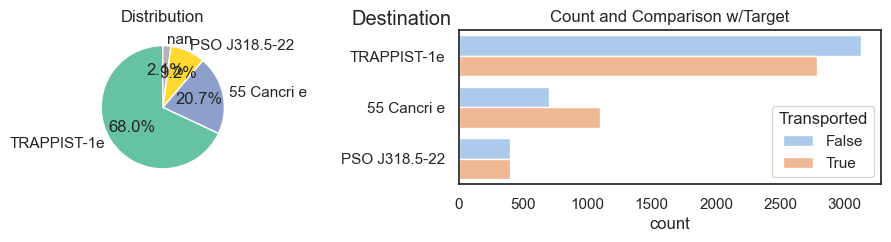

In [20]:
print(data['Destination'].value_counts(dropna=False))

# Plots
fig, ax = plt.subplots(1, 2, figsize=(12, 2))

# ax[0]
data['Destination'].value_counts(dropna=False).plot(kind='pie', autopct='%.1f%%', ax=ax[0], startangle=90, cmap='Set2')
ax[0].set_ylabel('')
ax[0].set_title('Distribution')

# ax[1]
sns.countplot(y=data['Destination'], order=data['Destination'].value_counts().index, ax=ax[1], hue=data['Transported'])
ax[1].set_ylabel('')
ax[1].set_title('Count and Comparison w/Target')


plt.suptitle('Destination')
plt.show()

# Similar to HomePlanet. Most passengers heading TRAPPIST-1e, 182 Nulls
# 55 Cancri e looks like they have a better Transported Rate

## Age (Feature)

Nulls: 179
Skewness: 0.419097 

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64


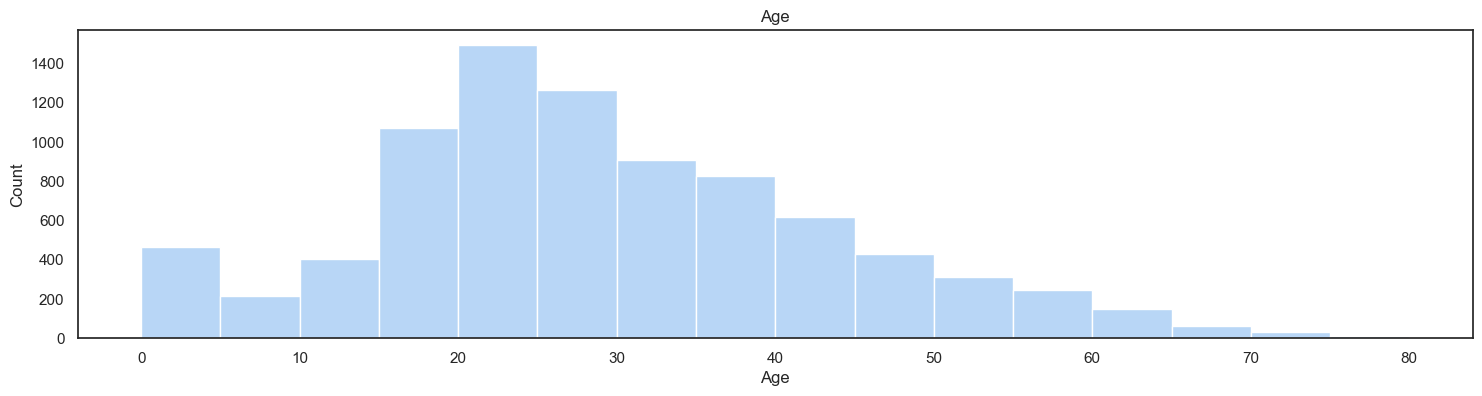

In [21]:
print('Nulls:', data['Age'].isnull().sum())
print("Skewness: %f" % data['Age'].skew(), '\n') # Right
print(data['Age'].describe())

# Plots
fig,ax=plt.subplots(1,1,figsize=(18,4))
sns.histplot(data=data['Age'], binwidth=5)

plt.title('Age')
plt.show()

# Will I have to descritize this one?

## VIP (Feature)

True      199
False    8291
NaN       203
Name: VIP, dtype: int64


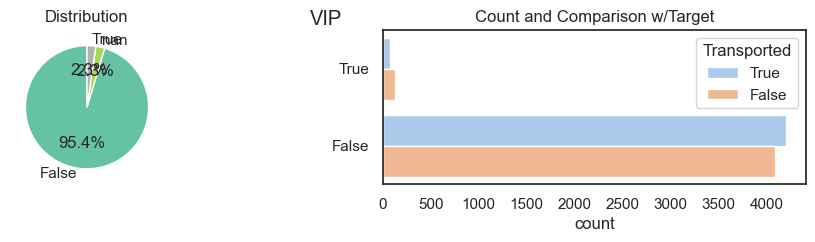

In [22]:
print(data['VIP'].value_counts(dropna=False).sort_index(ascending=False))

# Plot
fig,ax=plt.subplots(1,2,figsize=(12,2))

# ax[0]
data['VIP'].value_counts(dropna=False).plot(kind='pie', autopct='%.1f%%', startangle=90, cmap='Set2', ax=ax[0])
ax[0].set_ylabel('')
ax[0].set_title('Distribution')

# ax[1]
sns.countplot(y=data['VIP'], hue=data['Transported'], order=[True, False], hue_order=[True, False], ax=ax[1])
ax[1].set_ylabel('')
ax[1].set_title('Count and Comparison w/Target')
fig.suptitle('VIP')
plt.show()

# Few VIPS and few Nulls, nothing important here

## Name (Feature)

In [23]:
print('Nulls:', data['Name'].isnull().sum(), '\n')
print(data['Name'].value_counts())

# 200 nulls, couple of name repeted. Im pretty sure this Feature is useless

Nulls: 200 

Gollux Reedall        2
Elaney Webstephrey    2
Grake Porki           2
Sus Coolez            2
Apix Wala             2
                     ..
Jamela Griffy         1
Hardy Griffy          1
Salley Mckinn         1
Mall Frasp            1
Propsh Hontichre      1
Name: Name, Length: 8473, dtype: int64


 ## RoomService (Feature)

Nulls: 181 

count     8512.000000
mean       224.687617
std        666.717663
min          0.000000
25%          0.000000
50%          0.000000
75%         47.000000
max      14327.000000
Name: RoomService, dtype: float64


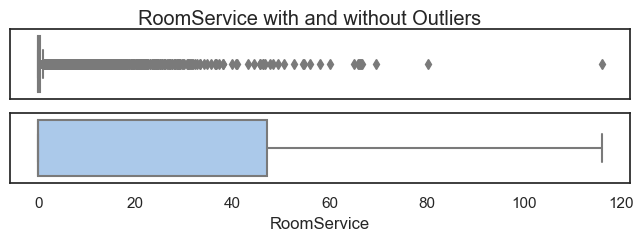

In [24]:
print('Nulls:', data['RoomService'].isnull().sum(), '\n')
print(data['RoomService'].describe())

# Plot
fig, ax = plt.subplots(2, 1, figsize=(8, 2))

# ax[0]
sns.boxplot(x=data['RoomService'], showfliers=True, ax=ax[0])
ax[0].set_ylabel('')

# ax[1]
sns.boxplot(x=data['RoomService'], showfliers=False, ax=ax[1])
ax[1].set_ylabel('')

fig.suptitle('RoomService with and without Outliers')
plt.show()

## FoodCourt (Feature)

Nulls: 183 

count     8510.000000
mean       458.077203
std       1611.489240
min          0.000000
25%          0.000000
50%          0.000000
75%         76.000000
max      29813.000000
Name: FoodCourt, dtype: float64


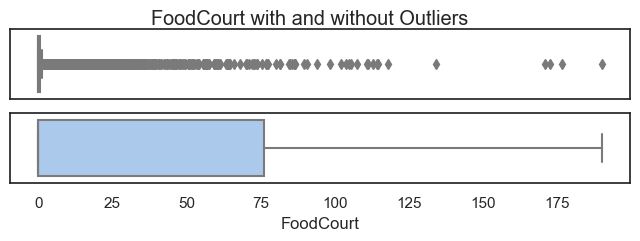

In [25]:
print('Nulls:', data['FoodCourt'].isnull().sum(), '\n')
print(data['FoodCourt'].describe())

# Plot
fig, ax = plt.subplots(2, 1, figsize=(8, 2))

# ax[0]
sns.boxplot(x=data['FoodCourt'], showfliers=True, ax=ax[0])
ax[0].set_ylabel('')

# ax[1]
sns.boxplot(x=data['FoodCourt'], showfliers=False, ax=ax[1])
ax[1].set_ylabel('')

fig.suptitle('FoodCourt with and without Outliers')
plt.show()

## ShoppingMall (Feature)

Nulls: 208 

count     8485.000000
mean       173.729169
std        604.696458
min          0.000000
25%          0.000000
50%          0.000000
75%         27.000000
max      23492.000000
Name: ShoppingMall, dtype: float64


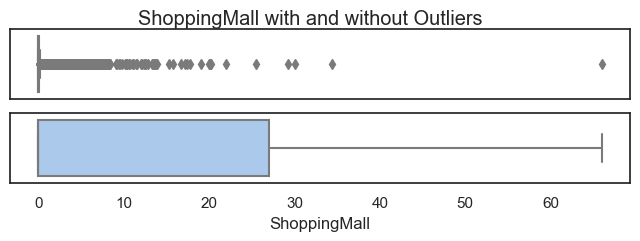

In [26]:
print('Nulls:', data['ShoppingMall'].isnull().sum(), '\n')
print(data['ShoppingMall'].describe())

# Plot
fig, ax = plt.subplots(2, 1, figsize=(8, 2))

# ax[0]
sns.boxplot(x=data['ShoppingMall'], showfliers=True, ax=ax[0])
ax[0].set_ylabel('')

# ax[1]
sns.boxplot(x=data['ShoppingMall'], showfliers=False, ax=ax[1])
ax[1].set_ylabel('')

fig.suptitle('ShoppingMall with and without Outliers')
plt.show()

## Spa (Feature)

Nulls: 183 

count     8510.000000
mean       311.138778
std       1136.705535
min          0.000000
25%          0.000000
50%          0.000000
75%         59.000000
max      22408.000000
Name: Spa, dtype: float64


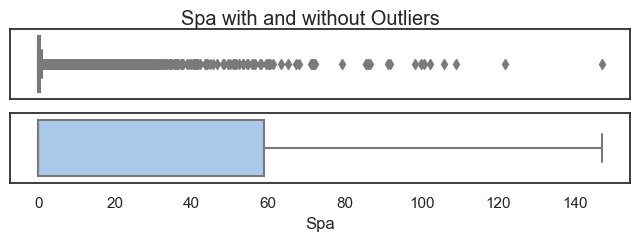

In [27]:
print('Nulls:', data['Spa'].isnull().sum(), '\n')
print(data['Spa'].describe())

# Plot
fig, ax = plt.subplots(2, 1, figsize=(8, 2))

# ax[0]
sns.boxplot(x=data['Spa'], showfliers=True, ax=ax[0])
ax[0].set_ylabel('')

# ax[1]
sns.boxplot(x=data['Spa'], showfliers=False, ax=ax[1])
ax[1].set_ylabel('')

fig.suptitle('Spa with and without Outliers')
plt.show()

## VRDeck (Feature)

Nulls: 188 

count     8505.000000
mean       304.854791
std       1145.717189
min          0.000000
25%          0.000000
50%          0.000000
75%         46.000000
max      24133.000000
Name: VRDeck, dtype: float64


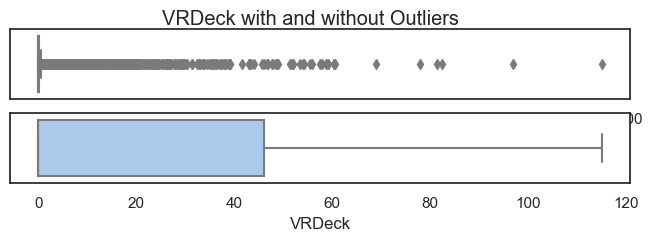

In [28]:
print('Nulls:', data['VRDeck'].isnull().sum(), '\n')
print(data['VRDeck'].describe())

# Plot
fig, ax = plt.subplots(2, 1, figsize=(8, 2))

# ax[0]
sns.boxplot(x=data['VRDeck'], showfliers=True, ax=ax[0])
ax[0].set_ylabel('')

# ax[1]
sns.boxplot(x=data['VRDeck'], showfliers=False, ax=ax[1])
ax[1].set_ylabel('')

fig.suptitle('VRDeck with and without Outliers')
plt.show()

# Spa (Feature)

Nulls: 183 

count     8510.000000
mean       311.138778
std       1136.705535
min          0.000000
25%          0.000000
50%          0.000000
75%         59.000000
max      22408.000000
Name: Spa, dtype: float64


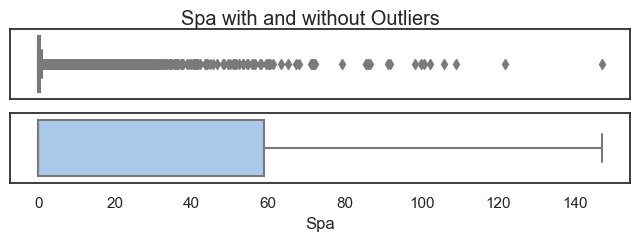

In [29]:
print('Nulls:', data['Spa'].isnull().sum(), '\n')
print(data['Spa'].describe())

# Plot
fig, ax = plt.subplots(2, 1, figsize=(8, 2))

# ax[0]
sns.boxplot(x=data['Spa'], showfliers=True, ax=ax[0])
ax[0].set_ylabel('')

# ax[1]
sns.boxplot(x=data['Spa'], showfliers=False, ax=ax[1])
ax[1].set_ylabel('')

fig.suptitle('Spa with and without Outliers')
plt.show()

# Weird values, probably we will ignore this Feature

## Continuous Features Comparation (PairPlot)

In [30]:
# Complete NA values with 0
# data_plot = pd.concat([data.select_dtypes(['float64']).drop(columns='Age').fillna(0), data['Transported']], axis=1)

# Plot
# sns.pairplot(data=data_plot, hue='Transported', hue_order=[True, False])
# plt.show()

# I can't find any insights

# Correcting and Completing Nulls

## HomePlanet (Feature)

In [31]:
# Counting and Checking nulls
print('Nulls Count:', data[data.HomePlanet.isnull()].shape[0], '\n')

Nulls Count: 201 



#### Groups Approach

In [32]:
# Passangers in Groups
display('Passengers in groups', data[data.HomePlanet.isnull() & ~(data.IsAlone)]
        [['PassengerId', 'HomePlanet', 'IsAlone']].head())
print('In groups with other passengers',data[data.HomePlanet.isnull() & ~(data.IsAlone)].shape[0])

# We can get HomePlanet from GroupId for almost 50% of NA. Lets check if this is a valid approach

'Passengers in groups'

,PassengerId,HomePlanet,IsAlone
59,0064_02,NaN,False
113,0119_01,NaN,False
405,0444_02,NaN,False
407,0445_02,NaN,False
438,0470_02,NaN,False


In groups with other passengers 92


In [33]:
# Lets confirm all members of each group departed from the same HomePlanet

data_grp_groupid_homeplanet = data.groupby(['GroupId', 'HomePlanet']).size().to_frame('Count').reset_index()
display(data_grp_groupid_homeplanet.head())

# There are no duplicated GroupId, so all are from the same HomePlanet
print('Is GroupId unique?:', data_grp_groupid_homeplanet.GroupId.is_unique)

# Filling Passangers in Groups with value from same GroupId
data.loc[:, 'HomePlanet'] = data.sort_values(by=['GroupId', 'HomePlanet'])['HomePlanet'].fillna(method='ffill')
print('Nulls Count HomePlanet:', data.HomePlanet.isnull().sum())

,GroupId,HomePlanet,Count
0,0001,Europa,1
1,0002,Earth,1
2,0003,Europa,2
3,0004,Earth,1
4,0005,Earth,1


Is GroupId unique?: True
Nulls Count HomePlanet: 0


#### Mode Approach

In [34]:
# Filling Solo Travelers with the mode # Not Necesary, nulls already 0
# data.loc[data.HomePlanet.isnull() & data.IsAlone, 'HomePlanet'] = data.HomePlanet.mode()[0]

# print('Nulls Count HomePlanet:', data.HomePlanet.isnull().sum())

## CryoSleep (Feature)

In [35]:
# Counting and Checking nulls
print('Nulls Count CryoSleep:', data[data.CryoSleep.isnull()].shape[0], '\n')

Nulls Count CryoSleep: 217 



#### Amenites Approcah

In [36]:
# Users spending money onboard are not in CryoSleeping
mask_amenities_expenses = (data.RoomService>0) | (data.FoodCourt>0) | (data.ShoppingMall>0) | (data.VRDeck>0)
data.loc[mask_amenities_expenses & data.CryoSleep.isnull(), 'CryoSleep'] = False

print('Nulls Count CryoSleep:', data[data.CryoSleep.isnull()].shape[0], '\n')

Nulls Count CryoSleep: 99 



#### Transported Approach

In [37]:
# Set True for Transported Passengers. Is this a good approach?

display(data.loc[data.CryoSleep.isnull() & data.Transported][['CryoSleep', 'Transported']])
data.loc[data.CryoSleep.isnull() & data.Transported, 'CryoSleep'] = True

print('\nNulls Count CryoSleep:', data[data.CryoSleep.isnull()].shape[0], '\n')

,CryoSleep,Transported
92,NaN,True
111,NaN,True
175,NaN,True
266,NaN,True
392,NaN,True
...,...,...
7756,NaN,True
8155,NaN,True
8362,NaN,True
8620,NaN,True



Nulls Count CryoSleep: 28 



#### GroupSize Approach

In [38]:
# Pending

#### VIP Approach

In [39]:
# Set to False for VIPs, any there are just 2
print(data[data.CryoSleep.isnull()].VIP.value_counts())
data.loc[data.CryoSleep.isnull() & data.VIP, 'CryoSleep'] = False

print('\nNulls Count CryoSleep:', data[data.CryoSleep.isnull()].shape[0], '\n')

False    25
Name: VIP, dtype: int64

Nulls Count CryoSleep: 28 



#### Mode Approach

In [40]:
# For the rest
data['CryoSleep'].fillna(data['CryoSleep'].mode()[0], inplace=True)

print('\nNulls Count CryoSleep:', data[data.CryoSleep.isnull()].shape[0], '\n')


Nulls Count CryoSleep: 0 



## Destination (Feature)

In [41]:
print('Nulls Count Destination:', data[data.Destination.isnull()].shape[0], '\n')

Nulls Count Destination: 182 



#### Mode Approach

In [42]:
data['Destination'].fillna(data['Destination'].mode()[0], inplace=True)
print('Nulls Count Destination:', data[data.Destination.isnull()].shape[0], '\n')

Nulls Count Destination: 0 



## Age (Feature)

In [43]:
print('Nulls Count Age:', data[data.Age.isnull()].shape[0], '\n')

Nulls Count Age: 179 



#### Median Approach

In [44]:
# Unnecesary, we will deal with Continous Features later

# data['Age'].fillna(data['Age'].median(), inplace=True)

# print('Nulls Count Age:', data[data.Age.isnull()].shape[0], '\n')

## VIP (Feature)

In [45]:
print('Nulls Count VIP:', data[data.VIP.isnull()].shape[0], '\n')

Nulls Count VIP: 203 



#### Mode Approach

In [46]:
data['VIP'].fillna(data['VIP'].mode()[0], inplace=True)
print('Nulls Count VIP:', data[data.VIP.isnull()].shape[0], '\n')

Nulls Count VIP: 0 



## Age & Amenities (Continuous Features)

In [47]:
continuous_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'VRDeck', 'Age'] #Age?

print('Nulls Count Amenities:', data[continuous_cols].isnull().sum())

Nulls Count Amenities: RoomService     181
FoodCourt       183
ShoppingMall    208
VRDeck          188
Age             179
dtype: int64


#### Median Approach

In [48]:
# Medians are 0, I'm not sure if this is a good approach

for col in continuous_cols:
    data[col].fillna(data[col].median(), inplace=True)


print('Nulls Count Amenities:', data[continuous_cols].isnull().sum())

Nulls Count Amenities: RoomService     0
FoodCourt       0
ShoppingMall    0
VRDeck          0
Age             0
dtype: int64


## Deck, Num, Side (Created Features)

In [49]:
print('Nulls Count Deck:', data[data.Deck.isnull()].shape[0], '\n')

Nulls Count Deck: 134 



#### DropNA

In [50]:
data.dropna(subset='Deck', inplace=True)

print('Nulls Count Deck:', data[data.Deck.isnull()].shape[0], '\n')

Nulls Count Deck: 0 



# Features Selection and Convertion

In [51]:
X_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 
          'FoodCourt', 'ShoppingMall', 'VRDeck', 'GroupId', 'GroupSize', 'IsAlone', 'Deck', 'Num', 'Side']

X = data[X_cols]
y = data['Transported']

print(X.info())
print('Target size:', y.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8559 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8559 non-null   object 
 1   CryoSleep     8559 non-null   bool   
 2   Destination   8559 non-null   object 
 3   Age           8559 non-null   float64
 4   VIP           8559 non-null   bool   
 5   RoomService   8559 non-null   float64
 6   FoodCourt     8559 non-null   float64
 7   ShoppingMall  8559 non-null   float64
 8   VRDeck        8559 non-null   float64
 9   GroupId       8559 non-null   object 
 10  GroupSize     8559 non-null   int64  
 11  IsAlone       8559 non-null   bool   
 12  Deck          8559 non-null   object 
 13  Num           8559 non-null   object 
 14  Side          8559 non-null   object 
dtypes: bool(3), float64(5), int64(1), object(6)
memory usage: 894.3+ KB
None
Target size: (8559,)


## Nominal Features 

In [52]:
nominal_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Side', 'Deck']
X_nominals = data[nominal_cols].astype('category').reset_index(drop=True)
print(X_nominals.info())

# in doubt: IsAlone(correlated with GroupSize), Deck (Nominal?), Num (Ordinal?)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8559 entries, 0 to 8558
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   HomePlanet   8559 non-null   category
 1   CryoSleep    8559 non-null   category
 2   Destination  8559 non-null   category
 3   VIP          8559 non-null   category
 4   Side         8559 non-null   category
 5   Deck         8559 non-null   category
dtypes: category(6)
memory usage: 51.3 KB
None


#### Encoding

In [53]:
from sklearn.preprocessing import OneHotEncoder
oh_encoder = OneHotEncoder(handle_unknown='infrequent_if_exist', sparse=False, drop='first')

X_nominals_encoded = oh_encoder.fit_transform(X_nominals)
X_nominals_encoded = pd.DataFrame\
    (X_nominals_encoded, columns=oh_encoder.get_feature_names_out()) # DF Shape

display(X_nominals_encoded.head())

,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_True,Side_S,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Ordinal Features

In [54]:
ordinal_cols = ['GroupSize']

X_ordinals = data[ordinal_cols].astype('category').reset_index(drop=True)
print(X_ordinals.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8559 entries, 0 to 8558
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   GroupSize  8559 non-null   category
dtypes: category(1)
memory usage: 8.8 KB
None


#### Encoding

In [55]:
from sklearn.preprocessing import OrdinalEncoder
ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

X_ordinals_encoded = ord_encoder.fit_transform(X_ordinals)
X_ordinals_encoded = pd.DataFrame\
    (X_ordinals_encoded, columns=ord_encoder.get_feature_names_out()) #DF Shape

display(X_ordinals_encoded.head())

,GroupSize
0,0.0
1,0.0
2,1.0
3,1.0
4,0.0


## Quantitative Features

In [56]:
X_continuous = data[continuous_cols].reset_index(drop=True)
print(X_continuous.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8559 entries, 0 to 8558
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RoomService   8559 non-null   float64
 1   FoodCourt     8559 non-null   float64
 2   ShoppingMall  8559 non-null   float64
 3   VRDeck        8559 non-null   float64
 4   Age           8559 non-null   float64
dtypes: float64(5)
memory usage: 334.5 KB
None


#### Encoding

In [57]:
from sklearn.preprocessing import KBinsDiscretizer

kbins_encoder = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

X_continuous_encoded = kbins_encoder.fit_transform(X_continuous)
X_continuous_encoded = pd.DataFrame(X_continuous_encoded, columns=kbins_encoder.get_feature_names_out())

## Target Feature

In [58]:
from sklearn.preprocessing import LabelEncoder
lb_encoder = LabelEncoder()

y_encoded = lb_encoder.fit_transform(data['Transported'])
y_encoded = pd.Series(y_encoded, name='Transported')

# Correlation

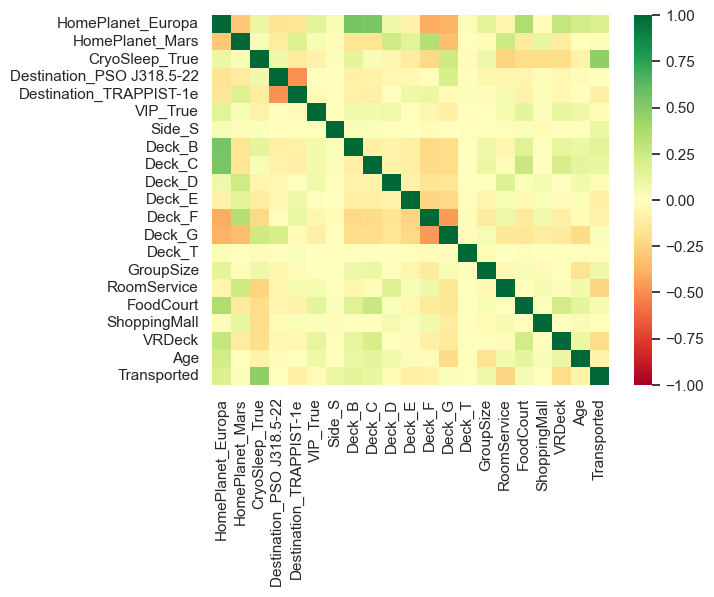

In [59]:
X_encoded = pd.concat([X_nominals_encoded, X_ordinals_encoded, X_continuous], axis=1)
data_tmp = pd.concat([X_encoded, y_encoded], axis=1)

sns.heatmap(data_tmp.corr(), vmin=-1, vmax=1, cmap='RdYlGn')
plt.show()

# Modeling

#### Pre-Procesing

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# Folds
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

#### Normalizacion

In [61]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler().fit(X_encoded[continuous_cols])
X_encoded[continuous_cols] = scaler.transform(X_encoded[continuous_cols]) # Comment for avoid Normalization

# Split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_encoded, y_encoded)

## Lazy Predict

In [79]:
# pip install lazypredict

import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score

models, predictions = LazyClassifier().fit(Xtrain, Xtest, ytrain, ytest)
display(models)

100%|██████████| 29/29 [00:16<00:00,  1.78it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.78,0.78,0.78,0.78,2.52
NuSVC,0.78,0.78,0.78,0.78,3.27
XGBClassifier,0.77,0.77,0.77,0.77,0.24
RandomForestClassifier,0.77,0.77,0.77,0.77,0.75
LGBMClassifier,0.77,0.77,0.77,0.77,0.09
AdaBoostClassifier,0.77,0.77,0.77,0.77,0.32
LinearSVC,0.76,0.76,0.76,0.76,0.43
CalibratedClassifierCV,0.76,0.76,0.76,0.76,1.89
BaggingClassifier,0.76,0.76,0.76,0.76,0.26


## KNN

In [63]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbros = np.arange(1, 31, 1)
weights = ['uniform', 'distance']
param_grid = dict(n_neighbors=n_neighbros, weights=weights)

model_knn = RandomizedSearchCV(estimator=KNeighborsClassifier(), 
                               param_distributions=param_grid, cv=cv)
model_knn.fit(Xtrain, ytrain)
ypred = model_knn.predict(Xtest)

# Print Scores
print(model_knn.best_score_)
print(model_knn.best_params_, '\n')
print(classification_report(ytest, ypred), '\n')

# Confusion Matrix
# fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# sns.heatmap(confusion_matrix(ytest, ypred), annot=True, fmt='d')
# plt.title('Confusion Matrix')
# plt.show()

0.7631505209509448
{'weights': 'uniform', 'n_neighbors': 29} 

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1056
           1       0.77      0.76      0.77      1084

    accuracy                           0.77      2140
   macro avg       0.77      0.77      0.77      2140
weighted avg       0.77      0.77      0.77      2140
 



# Naive-Bayes

In [80]:
from sklearn.naive_bayes import GaussianNB

model_NB = GaussianNB()
model_NB.fit(Xtrain, ytrain)
ypred = model_NB.predict(Xtest)

# Print Scores
print(classification_report(ytest, ypred), '\n')

# Confusion Matrix
# fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# sns.heatmap(confusion_matrix(ytest, ypred), annot=True, fmt='d')
# plt.title('Confusion Matrix')
# plt.show()

              precision    recall  f1-score   support

           0       0.89      0.24      0.38      1050
           1       0.57      0.97      0.72      1090

    accuracy                           0.61      2140
   macro avg       0.73      0.61      0.55      2140
weighted avg       0.73      0.61      0.55      2140
 



## Logistic Regresion

In [65]:
from sklearn.linear_model import LogisticRegression

penalty = ['none', 'l2', 'l1', 'elasticnet']
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(penalty=penalty, C=C)

model_LR = RandomizedSearchCV(estimator=LogisticRegression(), param_distributions=param_grid)
model_LR.fit(Xtrain, ytrain)
ypred = model_LR.predict(Xtest)

# Print Scores
print(model_LR.best_score_)
print(model_LR.best_params_, '\n')
print(classification_report(ytest, ypred), '\n')

# Confusion Matrix
# fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# sns.heatmap(confusion_matrix(ytest, ypred), annot=True, fmt='d')
# plt.title('Confusion Matrix')
# plt.show()

0.7647601148981529
{'penalty': 'none', 'C': 1} 

              precision    recall  f1-score   support

           0       0.75      0.78      0.76      1056
           1       0.77      0.75      0.76      1084

    accuracy                           0.76      2140
   macro avg       0.76      0.76      0.76      2140
weighted avg       0.76      0.76      0.76      2140
 



## Desicion Tree

In [66]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_encoded[continuous_cols])
# X_encoded.loc[continuous_cols]

X_encoded[continuous_cols] = scaler.transform(X_encoded[continuous_cols])

# Split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_encoded, y_encoded)

# Model
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# Hyper Parameters
n_estimators = np.arange(50, 151, 1)
criterion = ['gini', 'entropy', 'log_loss']
min_samples_leaf = [1, 2, 3]
max_features = ['auto', 'sqrt', 'log2']
param_grid = dict(n_estimators=n_estimators, criterion=criterion, max_features=max_features)

model_DT = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, cv=3)
model_DT.fit(Xtrain, ytrain)
ypred = model_DT.predict(Xtest)

# Print Scores
print(model_DT.best_score_)
print(model_DT.best_params_, '\n')
print(classification_report(ytest, ypred), '\n')

# Confusion Matrix
# fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# sns.heatmap(confusion_matrix(ytest, ypred), annot=True, fmt='d')
# plt.title('Confusion Matrix')
# plt.show()

0.77955882374359
{'n_estimators': 98, 'max_features': 'auto', 'criterion': 'entropy'} 

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      1050
           1       0.79      0.73      0.76      1090

    accuracy                           0.76      2140
   macro avg       0.77      0.77      0.76      2140
weighted avg       0.77      0.76      0.76      2140
 

